In [ ]:
!pip install torchvision==0.13.0
!pip install opencv-python==4.5.5.64
!pip install numpy==1.23.0
!pip install craft-text-detector

  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
craft-text-detector 0.4.3 requires opencv-python<4.5.4.62,>=3.4.8.29, but you have opencv-python 4.5.5.64 which is incompatible.
  Using cached opencv_python-4.5.4.60-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python-4.5.4.60-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.3 MB)
  Attempting uninstall: opencv-python
    Found existing installation: op

In [ ]:
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')


# Path to the IAM image data
# img_path = '/content/drive/My Drive/NLP Final Project Data/adam_writing.jpeg'

Mounted at /content/drive


# Vision Model

In [ ]:
%pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is inc

In [ ]:
# Define the dataset class
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(os.path.join(
            self.root_dir, file_name)).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label !=
                  self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(),
                    "labels": torch.tensor(labels)}
        return encoding


In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-base-printed')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Test specific example
url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True)[0]
print("Generated text:", generated_text)

Generated text: INDLUS THE


In [ ]:
model_path = '/content/drive/My Drive/NLP Final Project Data/IAM/best_model.pth'

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
import requests
from PIL import Image
# Test specific example
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSoolxi9yWGAT5SLZShv8vVd0bz47UWRzQC19fDTeE8GmGv_Rn-PCF1pP1rrUx8kOjA4gg&usqp=CAU'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True)[0]
print("Generated text:", generated_text)

Generated text: Hope you have alone it.


In [ ]:
!pip install easyocr


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import easyocr

# Initialize the reader
reader = easyocr.Reader(['en'])

image_path = '/content/drive/My Drive/NLP Final Project Data/tarun_writing.jpeg'

# Use detect instead of readtext
# Replace with your image path
result = reader.readtext(image_path)
words = []

for (bbox, text, prob) in result:
    words.append(text)
    print(f'Text: {text}, Probability: {prob}')

# Join the words into a single sentence
sentence = ' '.join(words)
print(f'Sentence: {sentence}')

Text: My, Probability: 0.5146355360608692
Text: nam@, Probability: 0.6814138293266296
Text: is, Probability: 0.8784467289366173
Text: Tasun ,, Probability: 0.43529216943150045
Text: Ir, Probability: 0.12678156957315181
Text: His, Probability: 0.7228809595108032
Text: lecfure ,, Probability: 0.5672356956468578
Text: we, Probability: 0.9574226418871301
Text: Itor n abod:, Probability: 0.246443788713477
Text: Cunt_ baxed, Probability: 0.18234708999227947
Text: Models, Probability: 0.6118700536693041
Text: feed, Probability: 0.9699692726135254
Text: frward, Probability: 0.3437384518347173
Text: N N, Probability: 0.7846963136728373
Text: Reeurert, Probability: 0.41215479428922985
Text: 6aed, Probability: 0.5771491527557373
Text: Arch;tedure, Probability: 0.20491247653656827
Text: Transfsr, Probability: 0.910502119630546
Text: meg, Probability: 0.5192724697267375
Text: ul), Probability: 0.6414728626843518
Text: N Ns, Probability: 0.9847185015678406
Sentence: My nam@ is Tasun , Ir His lecfure

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing results:

Processing text region 1:
EasyOCR Text: My
Probability: 0.5146355360608692
Cropped image size: (110, 126)
Processed image tensor shape: torch.Size([1, 3, 384, 384])
Your OCR Model Generated text: my

Processing text region 2:
EasyOCR Text: nam@
Probability: 0.6814138293266296
Cropped image size: (142, 50)
Processed image tensor shape: torch.Size([1, 3, 384, 384])
Your OCR Model Generated text: name

Processing text region 3:
EasyOCR Text: is
Probability: 0.8784467289366173
Cropped image size: (62, 70)
Processed image tensor shape: torch.Size([1, 3, 384, 384])
Your OCR Model Generated text: is

Processing text region 4:
EasyOCR Text: Tasun ,
Probability: 0.43529216943150045
Cropped image size: (236, 86)
Processed image tensor shape: torch.Size([1, 3, 384, 384])
Your OCR Model Generated text: Tanun.

Processing text region 5:
EasyOCR Text: Ir
Probability: 0.13059589457302623
Cropped image size: (126, 92)
Processed image tensor shape: torch.Size([1, 3, 384, 384])
Your

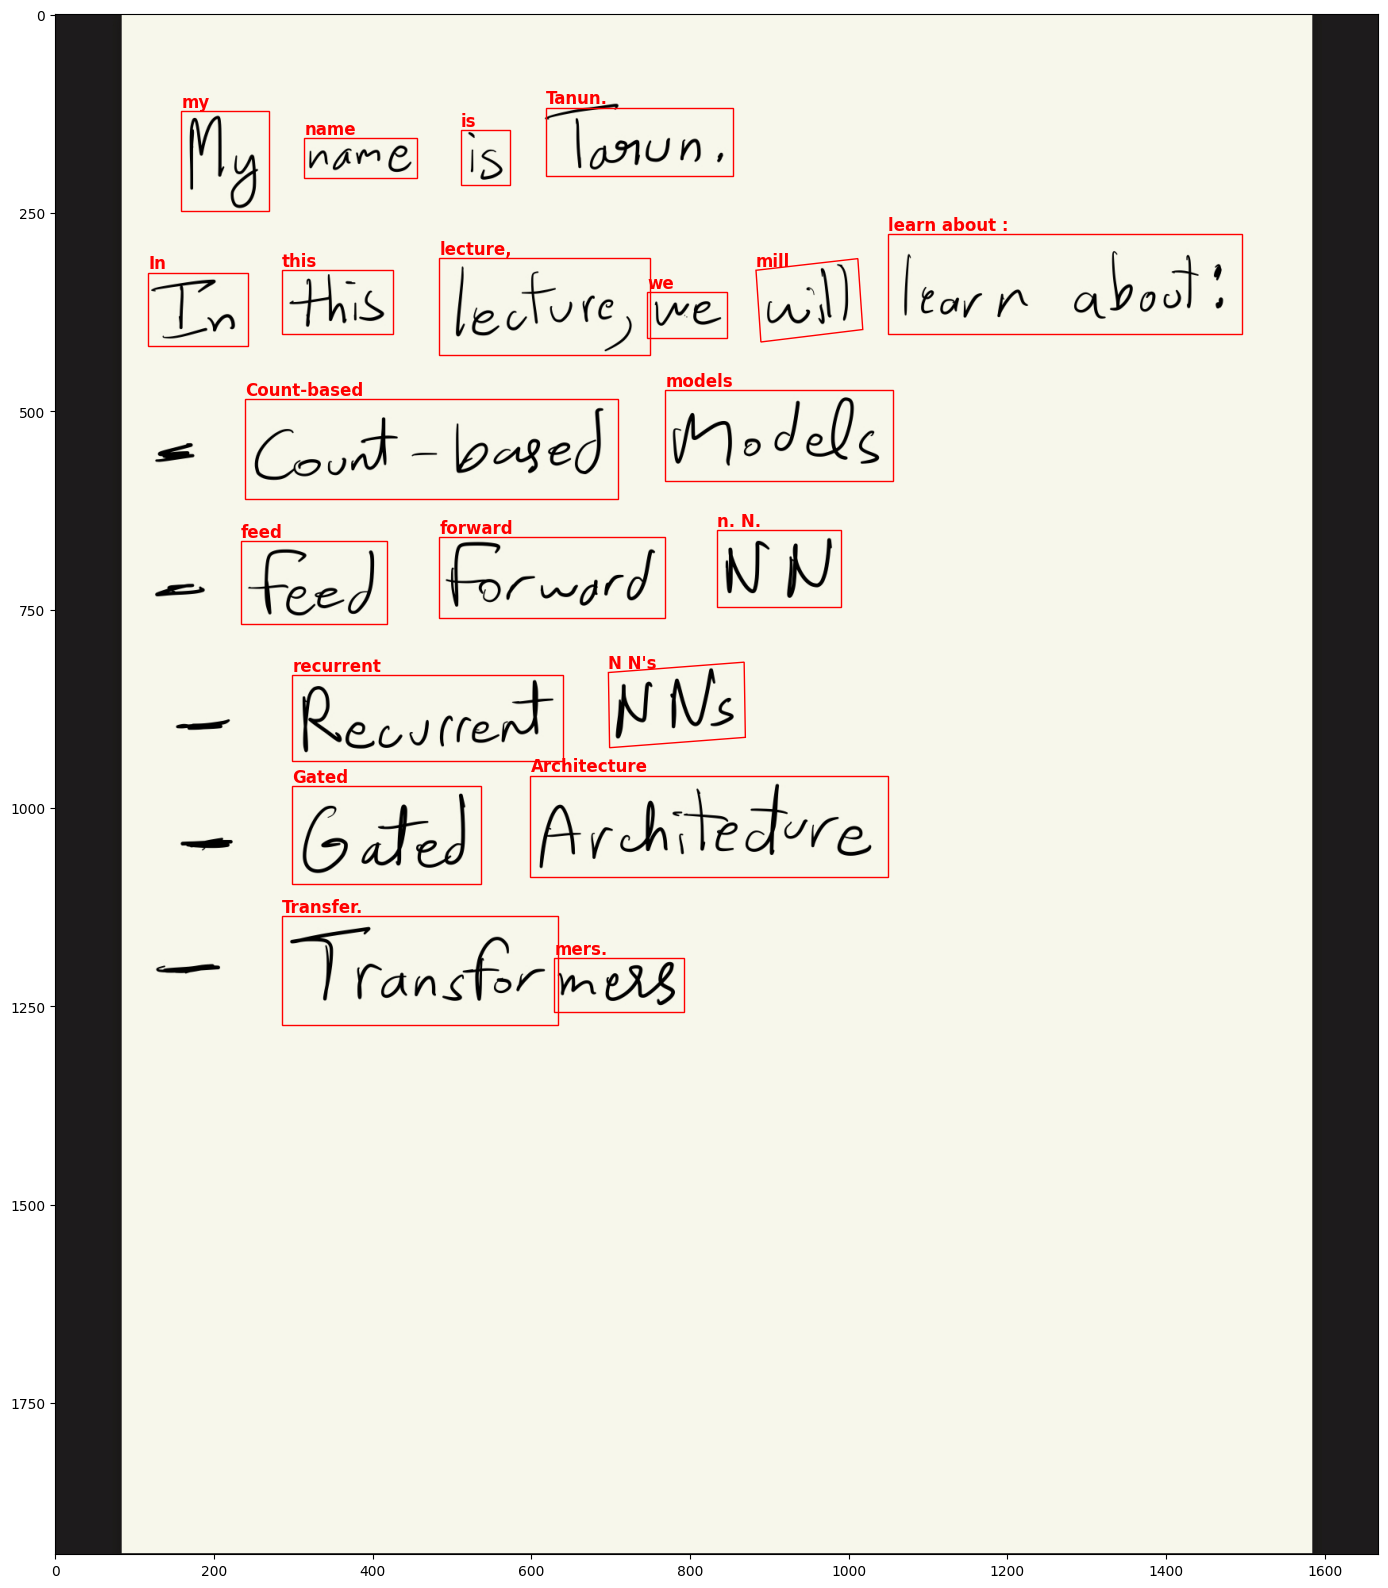

In [ ]:
import easyocr
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

def load_ocr_model(model_path = None):
    processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
    model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    return model, processor

def display_image_with_boxes(image_path, results):
    # Open the image
    image = Image.open(image_path)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(20, 20))

    # Display the image
    ax.imshow(image)

    # Draw each bounding box
    for result in results:
        bbox, text = result['bbox'], result['text']

        # Create a Polygon patch
        polygon = patches.Polygon(bbox, closed=True, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)

        # Add text annotation
        ax.text(bbox[0][0], bbox[0][1] - 5, text, color='r', fontsize=12, fontweight='bold')

    plt.show()

def process_image(image_path, model_path = None):
    # Initialize EasyOCR for text detection
    reader = easyocr.Reader(['en'])

    # Load your custom TrOCR model
    model, processor = load_ocr_model(model_path)

    # Perform text detection and recognition using EasyOCR
    easyocr_results = reader.readtext(image_path)

    # Open the full image
    full_image = Image.open(image_path)

    results = []

    print("Processing results:")
    for idx, (bbox, easyocr_text, prob) in enumerate(easyocr_results, 1):
        print(f"\nProcessing text region {idx}:")
        print(f"EasyOCR Text: {easyocr_text}")
        print(f"Probability: {prob}")

        # Calculate coordinates for cropping
        x_min = min(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_max = max(point[1] for point in bbox)

        # Ensure coordinates are integers
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        # Crop the image based on the bounding box
        cropped_image = full_image.crop((x_min, y_min, x_max, y_max))
        print(f"Cropped image size: {cropped_image.size}")

        # Preprocess the cropped image
        pixel_values = processor(cropped_image, return_tensors="pt").pixel_values
        print(f"Processed image tensor shape: {pixel_values.shape}")

        # Generate text using your model
        generated_ids = model.generate(pixel_values)

        # Decode the generated ids
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Your OCR Model Generated text: {generated_text}")

        results.append({
            'bbox': bbox,
            'text': generated_text
        })

    print("\nFinal Results:")
    for idx, result in enumerate(results, 1):
        print(f"Text Region {idx}:")
        print(f"Bounding Box: {result['bbox']}")
        print(f"Recognized Text: {result['text']}")
        print("---")

    # Display the image with bounding boxes
    display_image_with_boxes(image_path, results)

    return results

# Usage
image_path = '/content/drive/My Drive/NLP Final Project Data/tarun_writing.jpeg'
results = process_image(image_path)

In [ ]:
import easyocr
import torch
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

def load_ocr_model(model_path = None):
    processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
    model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    return model, processor

def process_image(image_path, model_path = None):
    # Initialize EasyOCR for text detection
    reader = easyocr.Reader(['en'])

    # Load your custom TrOCR model
    model, processor = load_ocr_model(model_path)

    # Perform text detection and recognition using EasyOCR
    easyocr_results = reader.readtext(image_path)

    # Open the full image
    full_image = Image.open(image_path)

    extracted_words = []

    print("Processing results:")
    for idx, (bbox, easyocr_text, prob) in enumerate(easyocr_results, 1):
        print(f"\nProcessing text region {idx}:")
        print(f"EasyOCR Text: {easyocr_text}")
        print(f"Probability: {prob}")

        # Calculate coordinates for cropping
        x_min = min(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_max = max(point[1] for point in bbox)

        # Ensure coordinates are integers
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

        # Crop the image based on the bounding box
        cropped_image = full_image.crop((x_min, y_min, x_max, y_max))

        # Preprocess the cropped image
        pixel_values = processor(cropped_image, return_tensors="pt").pixel_values

        # Generate text using your model
        generated_ids = model.generate(pixel_values)

        # Decode the generated ids
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        print(f"Your OCR Model Generated text: {generated_text}")

        # Add words to the list
        extracted_words.extend(generated_text.split())

    print("\nExtracted Words:")
    print(extracted_words)

    return extracted_words

# Usage
image_path = '/content/drive/My Drive/NLP Final Project Data/tarun_writing.jpeg'
word_list = process_image(image_path)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing results:

Processing text region 1:
EasyOCR Text: My
Probability: 0.5146355360608692
Your OCR Model Generated text: my

Processing text region 2:
EasyOCR Text: nam@
Probability: 0.6814138293266296
Your OCR Model Generated text: name

Processing text region 3:
EasyOCR Text: is
Probability: 0.8784467289366173
Your OCR Model Generated text: is

Processing text region 4:
EasyOCR Text: Tasun ,
Probability: 0.43529216943150045
Your OCR Model Generated text: Tanun.

Processing text region 5:
EasyOCR Text: Ir
Probability: 0.13059589457302623
Your OCR Model Generated text: In

Processing text region 6:
EasyOCR Text: His
Probability: 0.7228809595108032
Your OCR Model Generated text: this

Processing text region 7:
EasyOCR Text: lecfure ,
Probability: 0.5672356956468578
Your OCR Model Generated text: lecture,

Processing text region 8:
EasyOCR Text: we
Probability: 0.9574226418871301
Your OCR Model Generated text: we

Processing text region 9:
EasyOCR Text: Itor n abod:
Probability: 0.